In [1]:
import pandas as pd
import numpy as np
import os
import csv
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torch
from model import PoseRAC
import argparse
import time
import yaml
torch.multiprocessing.set_sharing_strategy('file_system')


# Normalization to improve training robustness.
def normalize_landmarks(all_landmarks, n_landmarks, n_dimensions):
#     x_max = np.expand_dims(np.max(all_landmarks[:,:,0], axis=1), 1)
#     x_min = np.expand_dims(np.min(all_landmarks[:,:,0], axis=1), 1)

#     y_max = np.expand_dims(np.max(all_landmarks[:,:,1], axis=1), 1)
#     y_min = np.expand_dims(np.min(all_landmarks[:,:,1], axis=1), 1)

#     if n_dimensions == 3:
#         z_max = np.expand_dims(np.max(all_landmarks[:,:,2], axis=1), 1)
#         z_min = np.expand_dims(np.min(all_landmarks[:,:,2], axis=1), 1)

#     all_landmarks[:,:,0] = (all_landmarks[:,:,0] - x_min) / (x_max - x_min)
#     all_landmarks[:,:,1] = (all_landmarks[:,:,1] - y_min) / (y_max - y_min)

#     if n_dimensions == 3:
#         all_landmarks[:,:,2] = (all_landmarks[:,:,2] - z_min) / (z_max - z_min)

    all_landmarks = all_landmarks.reshape(len(all_landmarks), n_landmarks*n_dimensions)
    return all_landmarks


# Original PoseRAC: For each pose, we use 33 key points to represent it, and each key point has 3 dimensions.
# Here we obtain the pose information (33*3=99) of each key frame, and set up the label (1 for salient pose I and 0 for salient pose II).
def obtain_landmark_label(csv_path, all_landmarks, all_labels, label2index, num_classes, n_landmarks, n_dimensions):
    file_separator=','
    with open(csv_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=file_separator)
        for row in csv_reader:
            assert len(row) == n_landmarks * n_dimensions + 2, 'Wrong number of values: {}'.format(len(row))
            landmarks = np.array(row[2:], np.float32).reshape([n_landmarks, n_dimensions])
            all_landmarks.append(landmarks)
            label = label2index[row[1]]

            start_str = row[0].split('/')[-3]
            label_np = np.zeros(num_classes)
            if start_str == 'salient1':
                label_np[label] = 1
            all_labels.append(label_np)
    return all_landmarks, all_labels


def csv2data(train_csv, action2index, num_classes, n_landmarks, n_dimensions):
    train_landmarks = []
    train_labels = []
    train_landmarks, train_labels = obtain_landmark_label(train_csv, train_landmarks, train_labels, action2index, num_classes, n_landmarks, n_dimensions)

    train_landmarks = np.array(train_landmarks)
    train_labels = np.array(train_labels)
    train_landmarks = normalize_landmarks(train_landmarks, n_landmarks, n_dimensions)

    return train_landmarks, train_labels



#     if os.path.isfile(args.config):
#         with open(args.config, "r") as fd:
#             config = yaml.load(fd, Loader=yaml.FullLoader)
#     else:
#         raise ValueError("Config file does not exist.")

#     csv_label_path = config['dataset']['csv_label_path']
#     root_dir = config['dataset']['dataset_root_dir']

#     train_csv = os.path.join(root_dir, 'annotation_pose', 'train.csv')

#     label_pd = pd.read_csv(csv_label_path)
#     index_label_dict = {}
#     length_label = len(label_pd.index)
#     for label_i in range(length_label):
#         one_data = label_pd.iloc[label_i]
#         action = one_data['action']
#         label = one_data['label']
#         index_label_dict[label] = action
#     num_classes = len(index_label_dict)
#     action2index = {v: k for k, v in index_label_dict.items()}
#     n_landmarks = config['PoseRAC']['n_landmarks']
#     n_dimensions = config['PoseRAC']['n_dimensions']

#     train_landmarks, train_labels = csv2data(train_csv, action2index, num_classes, n_landmarks, n_dimensions)
#     valid_landmarks, valid_labels = csv2data(train_csv, action2index, num_classes, n_landmarks, n_dimensions)

#     early_stop_callback = EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.00,
#         patience=20,
#         verbose=True,
#         mode='min',
#     )
#     ckpt_callback = ModelCheckpoint(mode="min",
#                                     monitor="val_loss",
#                                     dirpath='./saved_weights',
#                                     filename='{epoch}-{val_loss:.2f}',
#                                     every_n_epochs=1)

#     model = PoseRAC(train_landmarks, train_labels, valid_landmarks, valid_labels, dim=config['PoseRAC']['dim'],
#                     heads=config['PoseRAC']['heads'], enc_layer=config['PoseRAC']['enc_layer'],
#                     learning_rate=config['PoseRAC']['learning_rate'], seed=config['PoseRAC']['seed'],
#                     num_classes=num_classes, alpha=config['PoseRAC']['alpha'])

#     trainer = pl.Trainer(callbacks=[early_stop_callback, ckpt_callback], max_epochs=config['trainer']['max_epochs'],
#                          auto_lr_find=config['trainer']['auto_lr_find'], accelerator=config['trainer']['accelerator'],
#                          devices=config['trainer']['devices'], strategy='ddp')
    
#     trainer.tune(model)
#     print('Learning rate:', model.learning_rate)
#     trainer.fit(model)

#     print(f'best loss: {ckpt_callback.best_model_score.item():.5g}')

#     weights = model.state_dict()
#     torch.save(weights, config['save_ckpt_path'])

#     current_time = time.time()
#     print('time: ' + str(current_time - old_time) + 's')


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='Evaluate our PoseRAC')
#     parser.add_argument('--config', type=str, metavar='DIR',
#                         help='path to a config file')
#     args = parser.parse_args()
#     main(args)


In [4]:
config_path = './CowBytes_pose_config.yaml'

In [12]:
if os.path.isfile(config_path):
        with open(config_path, "r") as fd:
            config = yaml.load(fd, Loader=yaml.FullLoader)
else:
    raise ValueError("Config file does not exist.")

csv_label_path = config['dataset']['csv_label_path']
root_dir = config['dataset']['dataset_root_dir']

train_csv = os.path.join(root_dir, 'annotation_pose', 'train.csv')

label_pd = pd.read_csv(csv_label_path)
index_label_dict = {}
length_label = len(label_pd.index)
for label_i in range(length_label):
    one_data = label_pd.iloc[label_i]
    action = one_data['action']
    label = one_data['label']
    index_label_dict[label] = action
num_classes = len(index_label_dict)
action2index = {v: k for k, v in index_label_dict.items()}
n_landmarks = config['PoseRAC']['n_landmarks']
n_dimensions = config['PoseRAC']['n_dimensions']

train_landmarks, train_labels = csv2data(train_csv, action2index, num_classes, n_landmarks, n_dimensions)
valid_landmarks, valid_labels = csv2data(train_csv, action2index, num_classes, n_landmarks, n_dimensions)

In [13]:
train_landmarks

array([[ 3.2183240e+02,  6.0885754e+00,  3.7147617e+02, ...,
         1.8114557e+02,  1.8038106e+02,  1.9067520e+02],
       [ 3.2432785e+02,  5.4345531e+00,  3.6855811e+02, ...,
         1.8171416e+02,  1.8094431e+02,  1.9133255e+02],
       [ 4.4357248e+02,  2.2193956e+01,  2.4682561e+02, ...,
         1.3836745e+02,  3.1043860e+02,  2.5930182e+02],
       ...,
       [ 4.1672495e+02,  2.2872471e+01,  3.8974448e+02, ...,
         1.7652821e+02,  4.4822961e+02,  3.6142918e+01],
       [ 4.0374396e+02, -2.0828819e-01,  3.9122562e+02, ...,
         9.8638058e+00,  4.3190863e+02,  5.2954454e+00],
       [ 4.0374396e+02, -2.0828819e-01,  3.9122562e+02, ...,
         9.8638058e+00,  4.3190863e+02,  5.2954454e+00]], dtype=float32)

In [14]:
train_landmarks.shape

(1951, 54)

In [15]:
train_landmarks[0].shape

(54,)

In [16]:
train_landmarks[0]

array([321.8324   ,   6.0885754, 371.47617  , 287.6873   , 398.42032  ,
       285.69092  , 343.50897  , 289.8235   , 370.9953   , 302.22897  ,
       393.6459   , 296.75955  , 345.659    , 301.0947   , 388.82794  ,
       263.13742  , 351.14264  , 265.99637  , 405.80383  , 117.21983  ,
       277.34222  , 126.75521  , 406.10947  ,  68.36269  , 518.12177  ,
        72.88856  , 255.37753  ,  91.400505 , 135.88075  , 114.39171  ,
       378.07825  ,  38.862587 , 278.2626   ,  37.392998 , 319.12357  ,
         3.082319 , 328.35788  ,   2.112748 , 298.36206  , 307.05896  ,
       402.75238  , 290.93582  , 236.26065  , 309.32635  , 366.9486   ,
       294.399    , 172.52228  , 186.1624   , 166.91866  , 192.69693  ,
       168.32042  , 181.14557  , 180.38106  , 190.6752   ], dtype=float32)

In [17]:
landmarks[::2]

NameError: name 'landmarks' is not defined

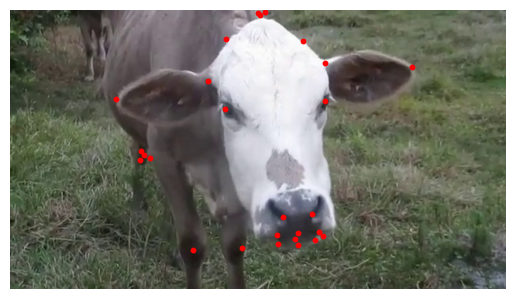

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '0.jpg'
image = Image.open(image_path)
image = np.array(image)

# Normalize coordinates
landmarks = train_landmarks[0]

# Image dimensions
height, width = image.shape[:2]

# Convert normalized coordinates to pixel coordinates
# num_landmarks = len(landmarks) // 2
x_coords = landmarks[::2] #* width
y_coords = landmarks[1::2] #* height

# Plotting
plt.imshow(image)
plt.scatter(x_coords, y_coords, c='red', s=10)  # 'c' is color, 's' is size of points
plt.axis('off')  # Hide axes
plt.show()


In [37]:
y_coords

array([ 42.71814, 733.6368 , 736.71295, 733.4195 , 801.4279 , 800.8486 ,
       791.1246 , 597.7056 , 610.5518 , 251.11638, 244.46912, 232.283  ,
       254.34328,  -1.     ,  -1.     ,  -1.     ,  -1.     ,  -1.     ,
        -1.     ,  -1.     ,  -1.     ,  -1.     ,  -1.     ,  -1.     ,
        -1.     ,  -1.     ,  -1.     ], dtype=float32)

In [38]:
height

1080

In [39]:
landmarks[num_landmarks:] 

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.], dtype=float32)